Given https://github.com/yutkin/Lenta.Ru-News-Dataset , perform EDA on it focusing on
the following:
- Provide descriptive statistics
- Anomaly detection

In [1]:
!pip install seaborn==0.12.2 corus==0.10.0 pymorphy2==0.9.1 nltk==3.8.1 gensim==4.3.2 pandas==1.5.3 scikit-learn==1.3.2 pyldavis==3.2.1 hyperopt==0.2.7 bigartm==0.9.2
![ ! -f lenta-ru-news.csv.gz ] && wget wget https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.0/lenta-ru-news.csv.gz
# ![ ! -f lenta-ru-news.csv ] && gunzip lenta-ru-news.csv.gz

In [2]:
import re
import pickle
import string
import random

from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd

from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

import spacy
import pyLDAvis
import pyLDAvis.gensim
import corus
import pymorphy2

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import artm

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

stopwordsru = stopwords.words('russian')
records = corus.load_lenta('lenta-ru-news.csv.gz')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def url2date(url):
    mat = re.search(r'(\d+/\d+/\d+)', url)
    return datetime.strptime(mat.group(), '%Y/%m/%d')

CLIPPED_COLS  = ['url', 'title', 'text', 'topic', 'tags', 'date']
CLIP_SIZE = 100

clipped_records = []
i = 0
for record in records:
    i += 1
    clipped_records.append([
        record.url,
        record.title,
        record.text,
        record.topic,
        record.tags,
        url2date(record.url),
    ])
    if i == CLIP_SIZE:
        break

lenta_data = pd.DataFrame(clipped_records, columns=CLIPPED_COLS)
lenta_data

url  \
0          https://lenta.ru/news/2018/12/14/cancer/   
1          https://lenta.ru/news/2018/12/15/doping/   
2      https://lenta.ru/news/2018/12/15/disneyland/   
3           https://lenta.ru/news/2018/12/15/usa25/   
4       https://lenta.ru/news/2018/12/15/integrity/   
..                                              ...   
95      https://lenta.ru/news/2018/12/14/champagne/   
96   https://lenta.ru/news/2018/12/14/moscowrental/   
97          https://lenta.ru/news/2018/12/14/david/   
98  https://lenta.ru/news/2018/12/14/haircolorfail/   
99            https://lenta.ru/news/2018/12/14/rus/   

                                                title  \
0   Названы регионы России с самой высокой смертно...   
1   Австрия не представила доказательств вины росс...   
2        Обнаружено самое счастливое место на планете   
3   В США раскрыли сумму расходов на расследование...   
4   Хакеры рассказали о планах Великобритании зами...   
..                                                ...   
95         Шампанское в России подорожает на четверть   
96  Снижение стоимости аренды квартир в Москве сме...   
97  Телеканал назвал президента чужим именем и опо...   
98     Новая прическа Мелании Трамп насмешила публику   
99  Финляндия закрыла программу изучения русского ...   

                                                 text           topic  \
0   Вице-премьер по социальным вопросам Татьяна Го...          Россия   
1   Австрийские правоохранительные органы не предс...           Спорт   
2   Сотрудники социальной сети Instagram проанализ...     Путешествия   
3   С начала расследования российского вмешательст...             Мир   
4   Хакерская группировка Anonymous опубликовала н...             Мир   
..                                                ...             ...   
95  Минимальная розничная цена шампанского в 2019 ...       Экономика   
96  С начала 2018 года ставки аренды жилья в росси...             Дом   
97  Телеканал Fox News, рассказывая о людях года п...  Интернет и СМИ   
98  Жена президента США Дональда Трампа Мелания Тр...        Ценности   
99  В Финляндии закрыли экспериментальную программ...             Мир   

           tags       date  
0      Общество 2018-12-14  
1   Зимние виды 2018-12-15  
2           Мир 2018-12-15  
3      Политика 2018-12-15  
4      Общество 2018-12-15  
..          ...        ...  
95        Рынки 2018-12-14  
96     Квартира 2018-12-14  
97   ТВ и радио 2018-12-14  
98  Внешний вид 2018-12-14  
99     Общество 2018-12-14  

[100 rows x 6 columns]

# EDA: tags and topics

In [5]:
topics = lenta_data['topic'].value_counts().sort_values(ascending=False)
topics_count = pd.DataFrame(topics)
topics_count = topics_count.rename(columns={'topic': 'count'})

tags = lenta_data['tags'].value_counts().sort_values(ascending=False)
tags_count = pd.DataFrame(tags)
tags_count  = tags_count.rename(columns={'tags': 'count'})
top_tags = tags_count[:15]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


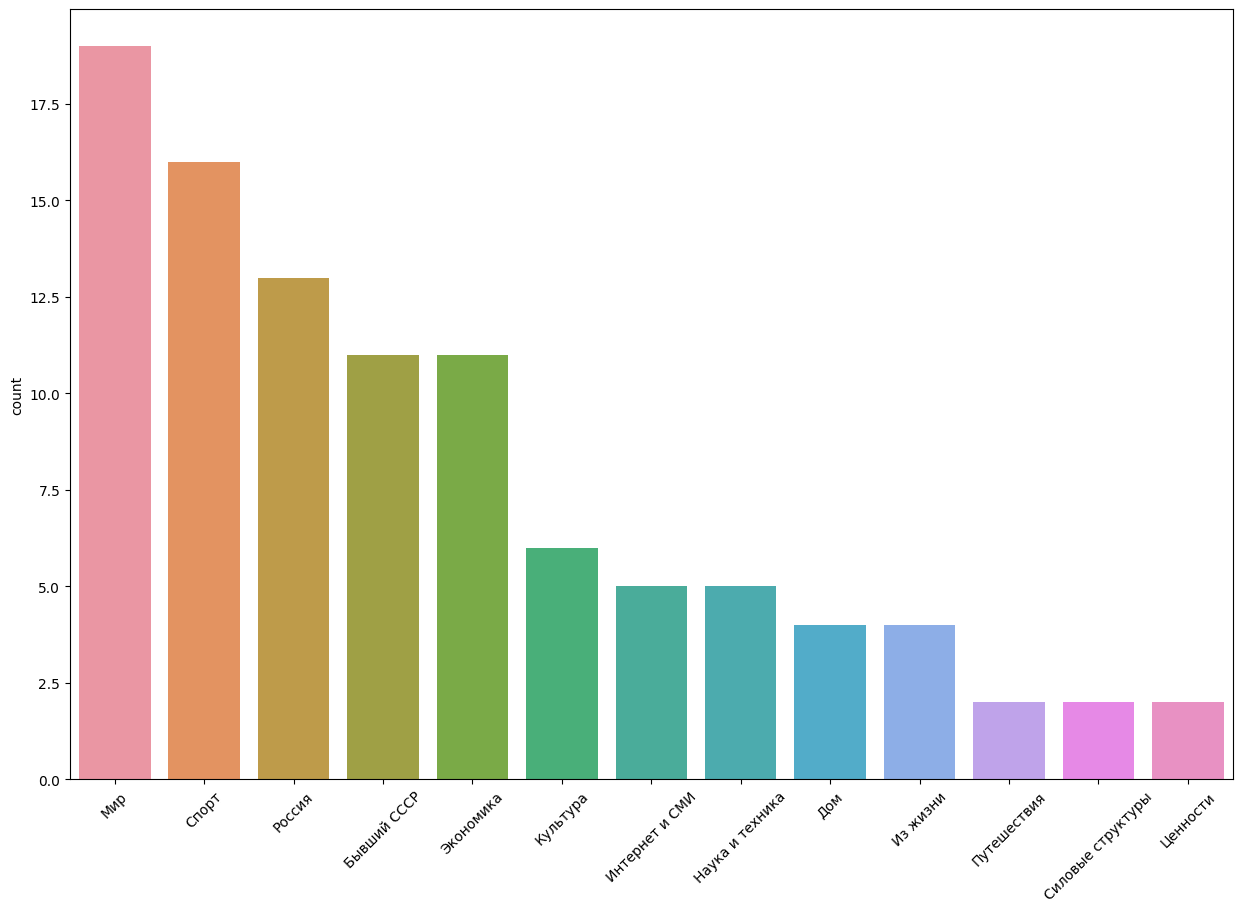

In [6]:
plt.figure(figsize=(15,10))
ax = sns.barplot(x=topics_count.index, y='count' , data=topics_count)
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


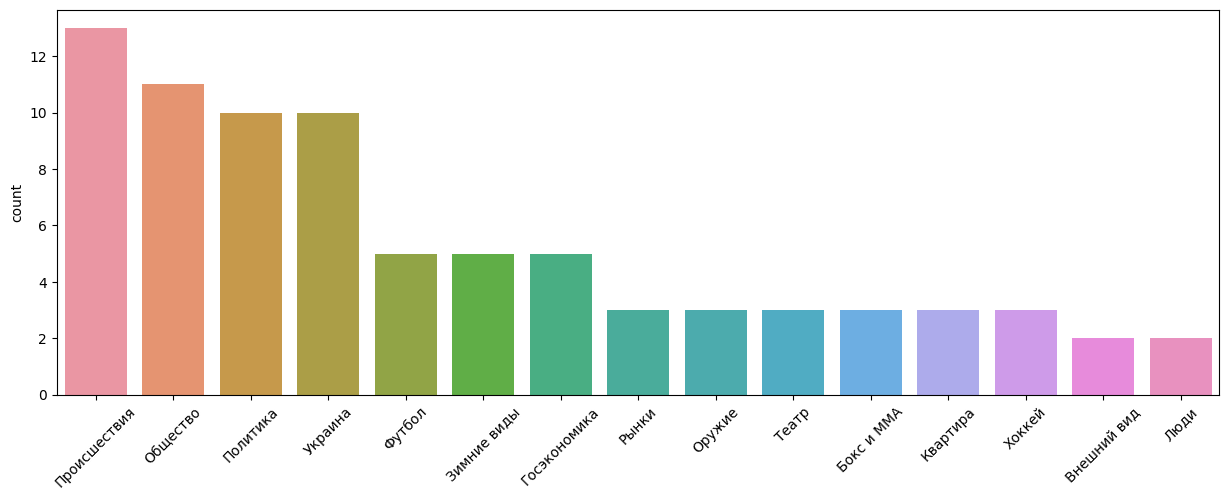

In [7]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x=top_tags.index, y='count' , data=top_tags)
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [8]:
counts_by_date = pd.DataFrame(lenta_data.groupby([lenta_data['date'].dt.year]).agg({'count'}))
counts_by_date = counts_by_date.drop(['url', 'text', 'date'], axis=1)
counts_by_date

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


title topic  tags
     count count count
date                  
2018   100   100   100

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1200x500 with 0 Axes>

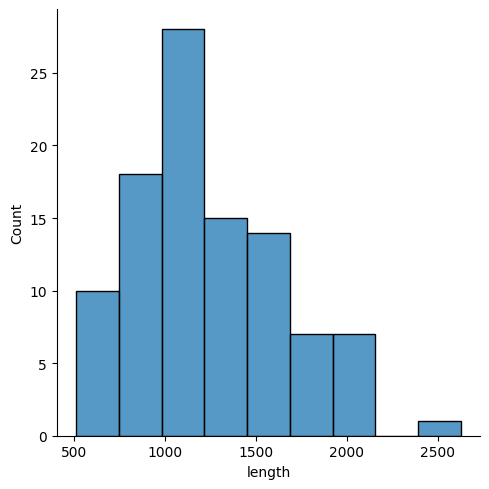

In [9]:
lenta_data['length']=lenta_data['text'].str.len()
lenta_data.dropna()
plt.figure(figsize=(12,5))

g = sns.displot(lenta_data['length'])
plt.show()

## LDA

In [10]:
morph = pymorphy2.MorphAnalyzer()

def process(text):
    result = []
    for word in word_tokenize(text):
        word = word.lower()
        if word.isalpha() and word not in stopwordsru:
            word_morphed  = morph.parse(word)[0]
            word_nf = word_morphed.normal_form
            result.append(word_nf)
    return result


lenta_data['processed_words'] = lenta_data['text'].apply(process)
lenta_data['processed_text'] = lenta_data['processed_words'].apply(' '.join)

# higher threshold fewer phrases
bigram = Phrases(lenta_data['processed_words'], min_count=5, threshold=100)
bigram_mod = Phraser(bigram)

trigram = Phrases(bigram[lenta_data['processed_words']], threshold=100)
trigram_mod = Phraser(trigram)

id2word_dict = Dictionary(lenta_data['processed_words'])
data_trigrams = [trigram_mod[bigram_mod[text]] for text in lenta_data['processed_words']]
corpus = [id2word_dict.doc2bow(text) for text in data_trigrams]

for item in data_trigrams:
  for token in item:
    if len(item) < 4 and '_' in token:
      print(item)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)


In [11]:
lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word_dict,
    num_topics=13,
    random_state=SEED,
    update_every=1,  # Number of documents to be iterated through for each update
    chunksize=10,  # == batch size
    passes=100,  # Number of passes through the corpus during training
    alpha='symmetric',  # A-priori belief on document-topic distribution
    iterations=150,  # Maximum number of iterations through the corpus when inferring the topic distribution of a corpus
    per_word_topics=True,
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


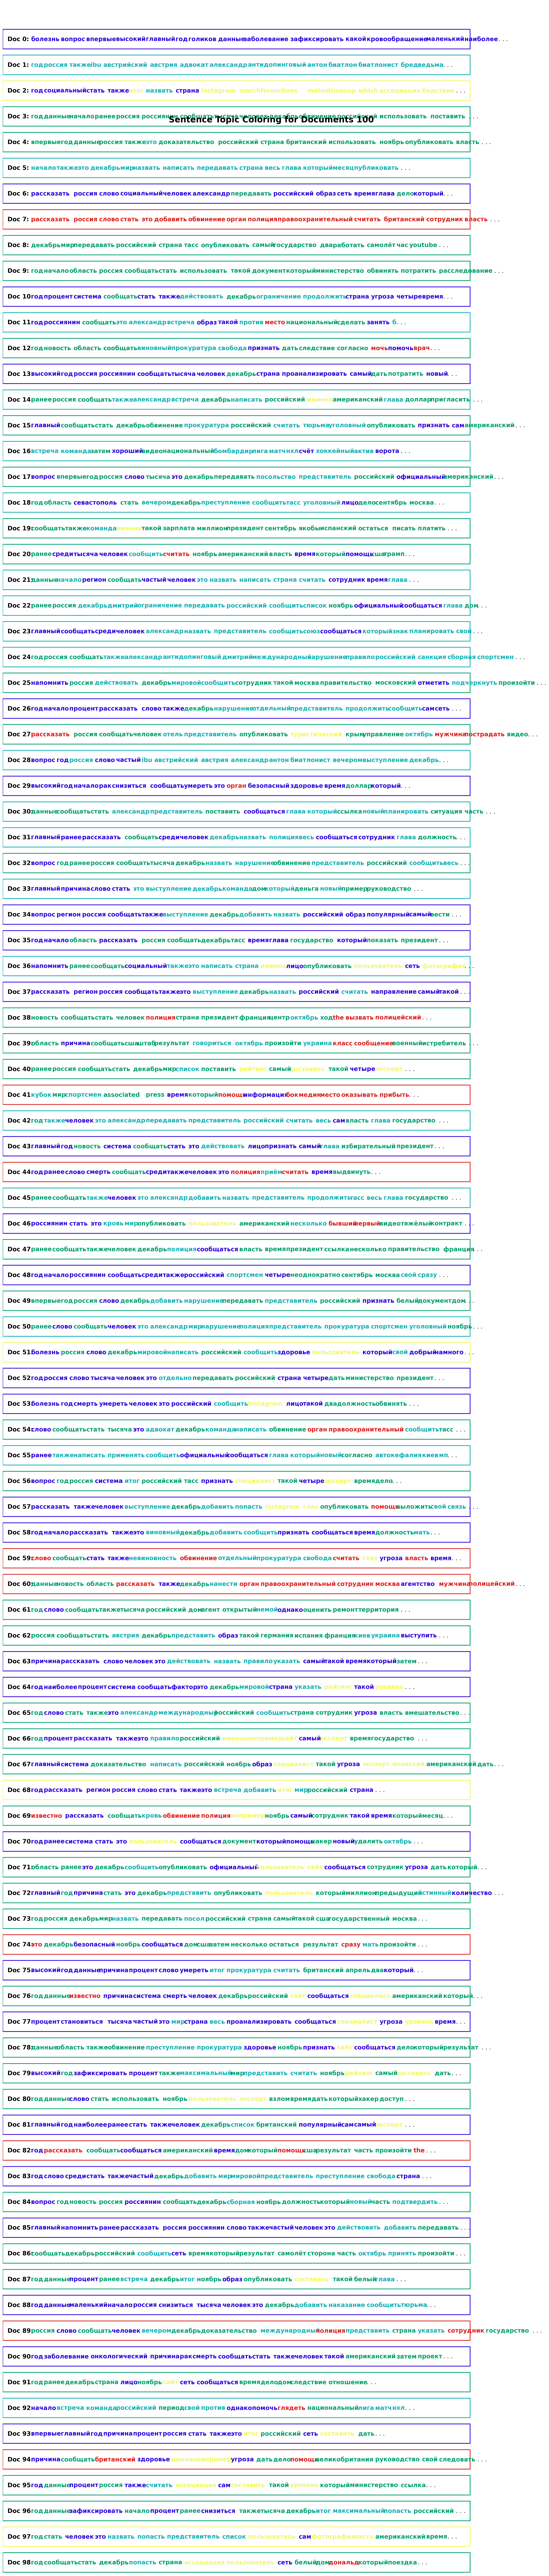

In [12]:
random_colors = ['#' + ''.join([random.choice('ABCDEF0123456789')
                         for i in range(6)])
                             for j in range(len(corpus))]

def sentences_chart():
    corp = corpus

    fig, axes = plt.subplots(len(corp), 1, figsize=(20, len(corp)*0.95), dpi=160)
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1]
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            # raise Exception(lda_model.id2word[53])
            # raise Exception(wordid_topics)
            word_dominanttopic = []
            for wd, topic in wordid_topics:
                if len(topic) == 0:
                    wd_topic = 0
                else:
                    wd_topic = topic[0]
                word_dominanttopic.append((lda_model.id2word[wd], wd_topic))

            ax.text(0.01,
                       0.5,
                       f'Doc {i-1}: ',
                       verticalalignment='center',
                       fontsize=16,
                       color='black',
                       transform=ax.transAxes,
                       fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            colors = random_colors[topic_percs_sorted[0][0]]
            ax.add_patch(mpatches.Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1,
                                   color=colors, linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=random_colors[topics],
                            transform=ax.transAxes, fontweight=600)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle(f'Sentence Topic Coloring for Documents {len(corp)}',
                 fontsize=22, y=0.95, fontweight=600)
    plt.tight_layout()
    plt.show()


sentences_chart()

In [13]:
lda_model.show_topics()

[(8,
  '0.000*"оперативный" + 0.000*"обучить" + 0.000*"предварительный" + 0.000*"помешать" + 0.000*"перевод" + 0.000*"отрицать" + 0.000*"разрушить" + 0.000*"опасаться" + 0.000*"медиум" + 0.000*"нахождение"'),
 (12,
  '0.000*"оперативный" + 0.000*"обучить" + 0.000*"предварительный" + 0.000*"помешать" + 0.000*"перевод" + 0.000*"отрицать" + 0.000*"разрушить" + 0.000*"опасаться" + 0.000*"медиум" + 0.000*"нахождение"'),
 (3,
  '0.000*"оперативный" + 0.000*"обучить" + 0.000*"предварительный" + 0.000*"помешать" + 0.000*"перевод" + 0.000*"отрицать" + 0.000*"разрушить" + 0.000*"опасаться" + 0.000*"медиум" + 0.000*"нахождение"'),
 (4,
  '0.026*"год" + 0.013*"это" + 0.012*"процент" + 0.012*"человек" + 0.010*"который" + 0.010*"ребёнок" + 0.009*"также" + 0.008*"время" + 0.008*"сказать" + 0.007*"слово"'),
 (11,
  '0.016*"церковь" + 0.013*"украина" + 0.011*"издание" + 0.010*"глава" + 0.010*"новый" + 0.010*"принять" + 0.010*"собор" + 0.010*"сообщить" + 0.009*"октябрь" + 0.009*"украинский"'),
 (10,
  '

## BigARTM

https://bigartm.readthedocs.io/en/stable/tutorials/regularizers_descr.html

In [14]:
TOPICS_CHECK =  [10, 15, 20]

lenta_data['processed_text'][0]

'социальный вопрос татьяна голиков рассказать какой регион россия зафиксировать наиболее высокий смертность рак сообщать риа новость слово голиков частый онкологический заболевание становиться причина смерть псковский тверской тульский орловский область также севастополь напомнить главный фактор смертность россия рак болезнь система кровообращение начало год стать известно смертность онкологический заболевание среди россиянин снизиться впервые год данные росстат год рак умереть тысяча человек это процент маленький год ранее'

In [15]:
cv = CountVectorizer(max_features=1000, max_df=0.8, min_df=2, ngram_range=(1, 2))
n_wd = np.array(cv.fit_transform(lenta_data['processed_text']).todense()).T

token_list = [i for i in cv.vocabulary_.keys()]
bv = artm.BatchVectorizer(data_format='bow_n_wd', n_wd=n_wd, vocabulary=token_list)

/usr/local/lib/python3.10/dist-packages/artm/batches_utils.py:227: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix


In [16]:
def objective(space):
    model = artm.ARTM(num_topics=space['num_topics'], dictionary=bv.dictionary, cache_theta=True)

    model.scores.add(artm.PerplexityScore(name='perplexity_score', dictionary=bv.dictionary))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score'))
    model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
    model.scores.add(artm.TopTokensScore(name='top_tokens_score', num_tokens=10))

    model.regularizers.add(
        artm.SmoothSparsePhiRegularizer(
          name='SparsePhi',
          tau=space['phi_tau']
      ),
    ) # Сглаживание распределений терминов в темах. Используется для выделения фоновых тем, собирающих общую лексику языка или общую лексику данной коллекции.
    model.regularizers.add(
        artm.SmoothSparseThetaRegularizer(
            name='SparseTheta',
            tau=space['theta_tau']
        ),
    ) # Сглаживание распределений тем в документах. Используется для выделения фоновых слов в каждом документах.
    model.regularizers.add(
        artm.DecorrelatorPhiRegularizer(
          name='DecorrelatorPhi',
          tau=space['decorrelation_tau']
        ),
    ) # Декоррелирование распределений терминов в темах. Используется для повышения различности лексических ядер предметных тем.

    model.fit_offline(bv, num_collection_passes=30)

    perplexity_score = model.score_tracker["perplexity_score"].last_value
    print("Perplexity:", perplexity_score)
    return {'loss': perplexity_score, 'status': STATUS_OK}


def run_hyperparams_search():
    space={
        'num_topics': hp.choice('num_topics', TOPICS_CHECK),
        'phi_tau': hp.uniform('SparsePhi', -1, 1),
        'theta_tau': hp.uniform('SparseTheta', -1, 1),
        'decorrelation_tau': hp.uniform('DecorrelatorPhi', 1e+2, 1e+5),
    }

    trials = Trials()

    best_hyperparams = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=20,
        trials=trials,
    )

    return best_hyperparams

best = run_hyperparams_search()

Perplexity:
330.0278625488281
Perplexity:
351.3939514160156
Perplexity:
861.697998046875
Perplexity:
463.1227111816406
Perplexity:
600.4974365234375
Perplexity:
360.3584289550781
Perplexity:
763.0866088867188
Perplexity:
985.7648315429688
Perplexity:
594.3248291015625
Perplexity:
435.05865478515625
Perplexity:
617.9853515625
Perplexity:
665.8809204101562
Perplexity:
325.8973388671875
Perplexity:
366.7708740234375
Perplexity:
306.4374694824219
Perplexity:
489.2987365722656
Perplexity:
367.30108642578125
Perplexity:
374.0593566894531
Perplexity:
397.02813720703125
Perplexity:
530.9526977539062
100%|██████████| 20/20 [00:11<00:00,  1.77trial/s, best loss: 306.4374694824219]


In [17]:
def fit_model():
    model = artm.ARTM(num_topics=TOPICS_CHECK[best['num_topics']],
                      dictionary=bv.dictionary, cache_theta=True,
                      seed=SEED)
    model.scores.add(artm.PerplexityScore(name='perplexity_score',
                                                              dictionary=bv.dictionary))

    model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score'))
    model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
    model.scores.add(artm.TopTokensScore(name='top_tokens_score',
                                                              num_tokens=10))

    # сглаживание/разреживание матрицы Phi
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=best['SparsePhi']))
    # сглаживание/разреживание матрицы Theta
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=best['SparseTheta']))
    # сделать темы более разнообразными
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=best['DecorrelatorPhi']))

    model.fit_offline(bv, num_collection_passes=30)

    return model

model = fit_model()
model.score_tracker["perplexity_score"].last_value

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


325.5555419921875

#### Perplexity

Мера несоответствия или «удивлённости» модели p(w | d) токенам w, наблюдаемым в документах d коллекции D. Перплексия равна экспоненте от минус усреднённого логарифма правдоподобия.

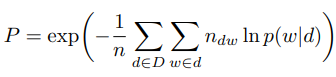


In [18]:
model.score_tracker["perplexity_score"].last_value

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


325.5555419921875

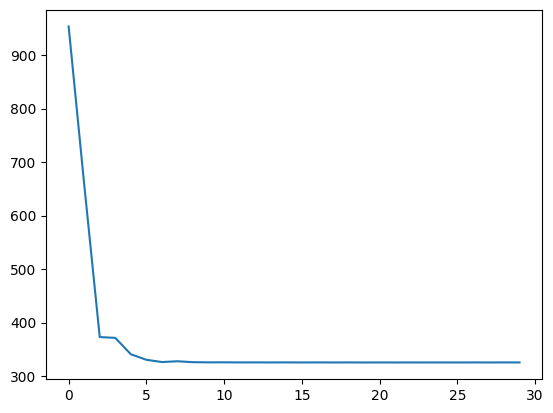

In [19]:
plt.plot(model.score_tracker["perplexity_score"].value)

#### Sparsity

Sparsity Phi - доля элементов матрицы $\Phi$ (или ее части), которые меньше заданного порогового значения eps.

In [20]:
model

artm.ARTM(num_topics=15, num_tokens=1000)

In [21]:
model.score_tracker["sparsity_phi_score"].last_value

0.9463333487510681

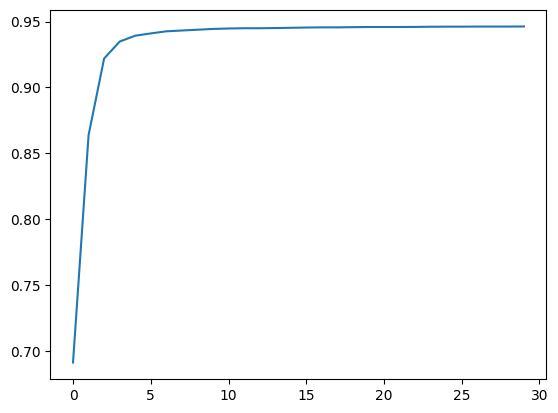

In [22]:
plt.plot(model.score_tracker["sparsity_phi_score"].value)

Sparsity Theta - доля элементов матрицы $\Theta$ (или ее части), которые меньше заданного порогового значения eps.

In [23]:
print(model.score_tracker["sparsity_theta_score"].last_value)

0.4779999852180481


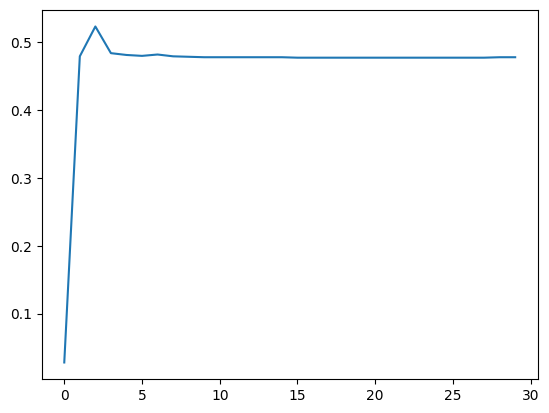

In [24]:
plt.plot(model.score_tracker["sparsity_theta_score"].value)

#### Topic diversity

[Adji B. Dieng, Francisco J. R. Ruiz, and David M. Blei. 2019. Topic modeling in embedding spaces](https://arxiv.org/pdf/1907.04907.pdf)

topic diversity - процент уникальных слов из топ num_words (10) слов для каждой из тем.

In [25]:
NUM_WORDS = 10

In [26]:
word_topics = []
for topic_name in model.topic_names:
  temp = []
  for word in model.score_tracker["top_tokens_score"].last_tokens[topic_name]:
    temp.append(word)
  word_topics.append(temp)

In [27]:
def td_score(topics):
  if topics is None:
    return 0
  if len(topics[0]) < NUM_WORDS:
    raise Exception(f'Words in topics are less than {NUM_WORDS}')
  else:
    unique_words = set()
    for topic in topics:
      unique_words = unique_words.union(set(topic[:NUM_WORDS]))
    td = len(unique_words) / (NUM_WORDS * len(topics))
    return td

td_score(word_topics)

0.9866666666666667

#### Coherence

Тематическая согласованность измеряет оценку одной темы путем измерения степени семантического сходства между высоко оцененными словами в теме

Показатель **c_v** извлекает количество совпадений для заданных слов с использованием скользящего окна. Счетчики используются для вычисления NPMI каждого топ-токена по отношению к другим топ-токенам, в результате чего получается набор векторов - по одному для каждого топ-токена. Сегментация по одному набору топ-токенов приводит к вычислению сходства между каждым вектором топ-токена и суммой всех векторов топ-токенов. В качестве меры сходства используется косинусное расстояние.

In [28]:
docs = []
for row in n_wd.T:
  docs.append([token_list[i] for i, value in enumerate(row) if value > 0])
dictionary = Dictionary(docs)

In [29]:
coherence_model = CoherenceModel(topics=word_topics, texts=docs, dictionary=dictionary, coherence='c_v')
coherence = coherence_model.get_coherence()
coherence

0.3962499964939273

### Визуализация

In [30]:
def prepare_vis_data():
    phi = model.get_phi()
    theta = model.get_theta().to_numpy().T
    theta = theta / theta.sum(axis=1, keepdims=1)
    data = {'topic_term_dists': phi.to_numpy().T,
            'doc_topic_dists': theta,
            'doc_lengths': n_wd.sum(axis=0).tolist(),
            'vocab': phi.T.columns,
            'term_frequency': n_wd.sum(axis=1).tolist()}
    return data

In [31]:
model_data = prepare_vis_data()
model_vis = pyLDAvis.prepare(**model_data)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [32]:
pyLDAvis.save_html(model_vis, 'lenta_bigartm_vis.html')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
pyLDAvis.display(model_vis)

#### Top tokens

In [34]:
def print_top_tokens():
  top_tokens = model.score_tracker['top_tokens_score']

  for topic_name in model.topic_names:
      print(topic_name + ': ')
      for (token, weight) in zip(top_tokens.last_tokens[topic_name], top_tokens.last_weights[topic_name]):
        print(f'{round(weight, 3)}*{token}', end=' + ')
      print()

print_top_tokens()

topic_0: 
0.055*иск + 0.055*упц + 0.042*правоохранительный + 0.034*случиться + 0.029*полёт + 0.029*власть + 0.027*здание + 0.025*the + 0.025*закон + 0.025*сша + 
topic_1: 
0.052*ожидать + 0.049*американский + 0.049*дело + 0.045*путь + 0.028*поддержать + 0.028*прийтись + 0.024*реакция + 0.024*проблема + 0.022*вывод + 0.02*угроза + 
topic_2: 
0.03*наш + 0.025*глава новый + 0.024*сообщение + 0.024*софийский собор + 0.021*продолжать + 0.019*добавлять + 0.019*протоиерей + 0.019*восемь + 0.018*приостановить действие + 0.018*открыть огонь + 
topic_3: 
0.21*отказаться участвовать + 0.171*дмитрий + 0.171*ракетоносец + 0.171*час + 0.093*москва + 0.074*принять решение + 0.054*медаль + 0.054*алексей + 
topic_4: 
0.069*граница + 0.06*правило + 0.052*результат + 0.052*производитель + 0.052*три + 0.043*пользователь + 0.043*стоить + 0.043*открытый + 0.043*мать + 0.043*международный + 
topic_5: 
0.094*вертолёт + 0.087*китай + 0.087*показать + 0.057*встреча + 0.05*специалист + 0.05*мп + 0.05*принять уча

Топ-10 токенов для каждой темы

In [35]:
for topic_name in model.topic_names:
    print(topic_name + ': ')
    for word in model.score_tracker["top_tokens_score"].last_tokens[topic_name]:
        print(word, end=',')
    print()

topic_0: 
иск,упц,правоохранительный,случиться,полёт,власть,здание,the,закон,сша,
topic_1: 
ожидать,американский,дело,путь,поддержать,прийтись,реакция,проблема,вывод,угроза,
topic_2: 
наш,глава новый,сообщение,софийский собор,продолжать,добавлять,протоиерей,восемь,приостановить действие,открыть огонь,
topic_3: 
отказаться участвовать,дмитрий,ракетоносец,час,москва,принять решение,медаль,алексей,
topic_4: 
граница,правило,результат,производитель,три,пользователь,стоить,открытый,мать,международный,
topic_5: 
вертолёт,китай,показать,встреча,специалист,мп,принять участие,популярный,состояние,предложить,
topic_6: 
российский биатлонист,например,здравоохранение,тысяча человек,инициировать президент,единый церковь,полуостров,доставить,письмо,объект,
topic_7: 
сообщать риа,аренда жильё,подтвердить,объём,министерство,процедура,запрет,воспитанник,рекордный,площадка,
topic_8: 
дальность,рамка,слезоточивый газ,достигнуть,кп,владимир,театр,украина пётр,политический,сша дональд,
topic_9: 
отчёт,смер